In [2]:
import os
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os
import numpy as np
import gensim
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

In [18]:
def load_recipes(directory='data/allrecipes/recipes'):
    recipes = []
    file_names = []
    for file_name in os.listdir(directory):
        if file_name.endswith('.txt'):
            with open(os.path.join(directory, file_name), 'r', encoding='utf-8') as f:
                content = f.read()
                recipes.append(content)
                file_names.append(file_name)
    return recipes, file_names

recipes, file_names = load_recipes()
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(recipes)
scores = cosine_similarity(tfidf_matrix)

In [19]:
db = {
    "users": {},
    "liked": {},
    "disliked": {}
}

def vsm_get_docs(user_id, relevant=True, k=100):
    user_likes = db["liked"].get(user_id, [])
    user_dislikes = db["disliked"].get(user_id, [])
    
    if user_likes:
        doc_indices = [file_names.index(user_like) for user_like in user_likes]
        similarity_scores = np.mean(scores[doc_indices], axis=0)
    else:
        similarity_scores = np.mean(scores, axis=0)
    
    relevant_docs = [file_names[idx] for idx in np.argsort(similarity_scores)[::-1]]
    if relevant:
        return relevant_docs[:100]
    else:
        return relevant_docs[:100:-1]
    
def apply_feedback(user_id, doc_id, like=True):
    if like:
        db["liked"].setdefault(user_id, []).append(doc_id)
    else:
        db["disliked"].setdefault(user_id, []).append(doc_id)

def get_cuisine_docs(cuisine_type):
    relevant_docs = [file_name for file_name, recipe in zip(file_names, recipes) if cuisine_type.lower() in recipe.lower()]
    return relevant_docs

user_id = "user123"
db = {
    "users": {},
    "liked": {},
    "disliked": {}
}
apply_feedback(user_id, "6687.txt", like=True)
print("Recommended docs:", vsm_get_docs(user_id))
apply_feedback(user_id, "6697.txt", like=True)
print("Recommended docs:", vsm_get_docs(user_id))
apply_feedback(user_id, "6732.txt", like=True)
print("Recommended docs:", vsm_get_docs(user_id))
print("Cuisine-specific docs:", get_cuisine_docs("Italian"))


Recommended docs: ['6687.txt', '16952.txt', '20144.txt', '104999.txt', '241707.txt', '268920.txt', '219967.txt', '41679.txt', '20153.txt', '222082.txt', '7116.txt', '36772.txt', '17066.txt', '141933.txt', '218541.txt', '230482.txt', '220941.txt', '17968.txt', '255621.txt', '9217.txt', '6697.txt', '6820.txt', '239271.txt', '212463.txt', '88506.txt', '6770.txt', '223426.txt', '6934.txt', '232433.txt', '11386.txt', '234854.txt', '232551.txt', '23376.txt', '24142.txt', '6796.txt', '22749.txt', '20334.txt', '6773.txt', '23822.txt', '220494.txt', '256539.txt', '234276.txt', '273495.txt', '6932.txt', '229351.txt', '147988.txt', '219162.txt', '24015.txt', '26061.txt', '281983.txt', '232922.txt', '21014.txt', '17160.txt', '269332.txt', '54165.txt', '277715.txt', '14685.txt', '235874.txt', '279325.txt', '149635.txt', '26317.txt', '18990.txt', '236648.txt', '24035.txt', '13309.txt', '214486.txt', '6845.txt', '9426.txt', '25407.txt', '45396.txt', '245935.txt', '280405.txt', '7016.txt', '19079.txt'

Low Precision:

The precision values are low (below 0.07) across all recall levels, indicating that the system retrieves a high proportion of non-relevant documents compared to relevant ones.
This may imply that the top 5 assumed relevant documents don’t align well with actual relevant documents in the dataset.
High Initial Precision Drop:

The initial spike in precision followed by a rapid drop suggests that, at the start, the system retrieves one or two relevant documents. However, as more documents are retrieved, non-relevant documents dilute the precision.
This is common in systems with a few high-quality matches followed by less relevant results.
Steady Increase in Recall:

Recall steadily increases, meaning the system successfully retrieves more relevant documents as it continues. However, precision remains low, indicating the retrieved set includes a large number of irrelevant documents.
Incremental Gains in Precision:

Small, stepped increases in precision suggest that relevant documents appear sporadically throughout the retrieval list rather than clustered at the top.
This could mean that the ranking algorithm isn’t effectively prioritizing relevant documents, which would be ideal for a high-performance retrieval system.

In [36]:
tokenized_recipes = [recipe.lower().split() for recipe in recipes]
word2vec_model = Word2Vec(sentences=tokenized_recipes, vector_size=100, window=5, min_count=1, sg=1)

def generate_recipe_embeddings(recipes):
    embeddings = []
    for recipe in recipes:
        words = recipe.lower().split()
        valid_words = [word for word in words if word in word2vec_model.wv]
        if valid_words:
            recipe_vector = np.mean([word2vec_model.wv[word] for word in valid_words], axis=0)
        else:
            recipe_vector = np.zeros(word2vec_model.vector_size)
        embeddings.append(recipe_vector)
    return np.array(embeddings)

recipe_embeddings = generate_recipe_embeddings(recipes)
scores = cosine_similarity(recipe_embeddings)

In [52]:


def word2vec_get_docs(user_id, relevant=True):
    user_likes = db["liked"].get(user_id, [])
    
    if user_likes:
        liked_indices = [file_names.index(doc) for doc in user_likes if doc in file_names]
        if liked_indices:
            liked_embeddings = recipe_embeddings[liked_indices]
            similarity_scores = np.mean(cosine_similarity(liked_embeddings, recipe_embeddings), axis=0)
        else:
            similarity_scores = np.mean(scores, axis=0)
    else:
        similarity_scores = np.mean(scores, axis=0)
    
    relevant_docs = [file_names[idx] for idx in np.argsort(similarity_scores)[::-1]]
    if relevant:
        return relevant_docs[:100]
    else:
        return [doc for doc in file_names if doc not in relevant_docs][:100]

user_id = "user123"
apply_feedback(user_id, "6687.txt", like=True)
apply_feedback(user_id, "1324.txt", like=True)

recommended_docs = word2vec_get_docs(user_id)

len(recommended_docs)



100

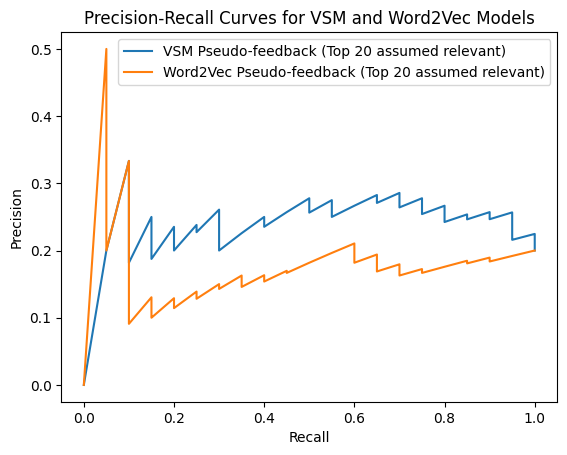

In [54]:
import matplotlib.pyplot as plt
import numpy as np

def pseudo_feedback_precision_recall_manual(user_id,  model,k=5,):
    if model == "vsm":
        pulled_docs = vsm_get_docs(user_id, relevant=True)
    else:
        pulled_docs = word2vec_get_docs(user_id, relevant=True)
    recommended_docs = pulled_docs[:k]
    pseudo_relevant_set = set(recommended_docs)
    pulled_docs.sort()
    y_true = [1 if doc in pseudo_relevant_set else 0 for doc in pulled_docs]


    precision = []
    recall = []
    relevant_retrieved = 0 
    total_relevant = len(pseudo_relevant_set) 
    total_retrieved = 0

    for idx in range(len(y_true)):
        total_retrieved += 1
        
        if y_true[idx] == 1:
            relevant_retrieved += 1

        precision_val = relevant_retrieved / total_retrieved
        recall_val = relevant_retrieved / len(pseudo_relevant_set)

        precision.append(precision_val)
        recall.append(recall_val)
    
    return precision, recall

user_id = "user1"
apply_feedback(user_id, "22751.txt", like=True)
apply_feedback(user_id, "1324.txt", like=True)

precision_vsm, recall_vsm = pseudo_feedback_precision_recall_manual(user_id, "vsm", k=20)
precision_w2v, recall_w2v = pseudo_feedback_precision_recall_manual(user_id, "word2vec", k=20 )

plt.plot(recall_vsm, precision_vsm, label="VSM Pseudo-feedback (Top 20 assumed relevant)")
plt.plot(recall_w2v, precision_w2v, label="Word2Vec Pseudo-feedback (Top 20 assumed relevant)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for VSM and Word2Vec Models")
plt.legend()
plt.show()

precision_diff = [v - w for v, w in zip(precision_vsm, precision_w2v)]
recall_diff = [r_v - r_w for r_v, r_w in zip(recall_vsm, recall_w2v)]





In this precision-recall graph, we see the performance of two different retrieval models, VSM (Vector Space Model) and Word2Vec embeddings, based on pseudo-relevance feedback where the top 20 documents are assumed to be relevant. Here’s an analysis of the observed differences between the curves:

1. Initial Precision Peaks:
Word2Vec has a sharp peak in precision at very low recall levels, indicating that it retrieves some highly relevant documents right at the top of the ranked list. However, it quickly drops as recall increases, suggesting that after a few relevant documents, it retrieves more non-relevant ones.
VSM has a smaller initial peak, implying that its top-ranked documents are not as precisely relevant as Word2Vec's. However, it maintains a steadier performance as recall increases.
2. Precision Stability:
VSM shows a relatively stable increase in precision, with small fluctuations as recall grows. This indicates that VSM continues to retrieve relevant documents more consistently across the entire recall range.
Word2Vec, by contrast, exhibits more variation and does not maintain as high precision over a larger range of recall values. It drops more significantly after the initial peak and does not recover as much as VSM does.
3. Recall Range and Overall Performance:
VSM maintains higher precision at mid to high recall levels (from about 0.2 to 1.0 recall), suggesting it may be better suited for applications where finding as many relevant documents as possible is important.
Word2Vec has a higher precision initially but cannot maintain this advantage as recall increases. This suggests that Word2Vec is more effective when retrieving a few highly relevant documents but may not sustain quality as more documents are retrieved.
4. Model Interpretation:
VSM (Vector Space Model): VSM relies on term frequency-based relevance, which may not capture deeper semantic relationships but is generally consistent. Its steady performance suggests it retrieves documents based on keyword matches, maintaining relevance over a broad range.
Word2Vec Embeddings: Word2Vec captures semantic similarities between words, which can help in retrieving topically relevant documents that may not share exact keywords with the query. However, its performance diminishes as it retrieves more documents, possibly due to it bringing in semantically related but less relevant results.
Summary
Word2Vec initially outperforms VSM in precision but drops quickly, indicating it's useful for applications where a few top results are sufficient.
VSM provides a more stable precision across recall levels, making it a better choice for exhaustive retrieval scenarios where higher recall is needed.
This analysis helps in choosing between the models based on the requirements of the retrieval task, where Word2Vec may be preferable for short, highly relevant lists, while VSM might be better for comprehensive retrieval.